<p>Tutorial by Raymond Yuan, Software Engineering Intern at Tensorflow</p>
<a href="https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398">Link to tutorial</a>

<h1> Neural Style Transfer </h1> 
Neural style transfer is an optimization technique used to take three images, a content image, a style reference image (such as an artwork by a famous painter), and the input image you want to style -- and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

<p>The principle of neural style transfer is to define two distance functions, one that describes how different the content of two images are , $L_{content}$, and one that describes the difference between two images in terms of their style, $L_{style}$. Then, given three images, a desired style image, a desired content image, and the input image (initialized with the content image), we try to transform the input image to minimize the content distance with the content image and its style distance with the style image.</p>

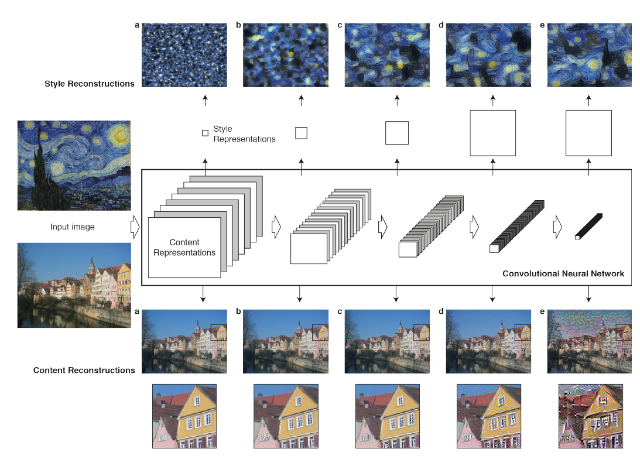

In [ ]:
import matplotlib.pyplot as plt
import os
import urllib
import time
import functools
import numpy as np
from PIL import Image


import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [10]:
img_dir = './tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

files = ["https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg",
         "https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg",
         "https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg",
         "https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg",
         "https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg",
         "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"]

for file in files:
    link_str = file.split("/")
    urllib.request.urlretrieve(file, filename="./tmp/nst/"+link_str[len(link_str)-1])

In [4]:
content_path = './tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = './tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

In [5]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    
    img = kp_image.img_to_array(img)
    
    # Expandig image to have a batch dimension
    img = np.expand_dims(img, axis=0)
    return img

In [7]:
def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

Eager execution: True


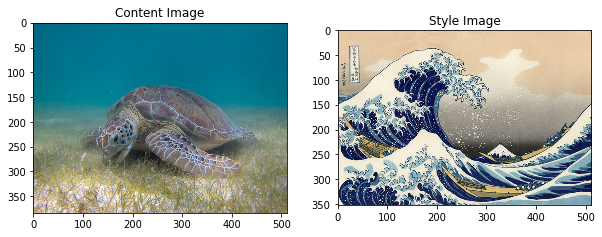

In [8]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

# Here are the content and style images we will use:
plt.figure(figsize=(10, 10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

<p>You may be wondering why these intermediate outputs within our pretrained image classification network allow us to define style and content representations. At a high level, this phenomenon can be explained by the fact that in order for a network to perform image classification (which our network has been trained to do), it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image. This is also partly why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g., cats vs. dogs) that are agnostic to background noise and other nuisances.</p>

In [9]:
# Content layer where will pull our features maps
content_layers = ['block5_conv2']

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
def get_model():
    """ Create our model with acces to intemediate layers."""
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    # Get output layers corresponding to style and content layers
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    # Build models
    return models.Model(vgg.input, model_outputs)

<p>Let $X$ be any image, then $C_{nn}(X)$ is the network fed by X. Let $F^l_{ij}(x) \in C_{nn}(x)$ and $P^l_{ij}(p) \in C_{nn}(p)$ describe the respective intermediate feature representation of the network with inputs $x$ and $p$ at layer $l$. Then we describe the content distance (loss) formally as:$$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$

We perform backpropagation in the usual way such that we minimize this content loss. We thus change the initial image until it generates a similar response in a certain layer (defined in content_layer) as the original content image.</p>

In [11]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

<p>we describe the style loss of the base input image, $x$, and the style image, $a$, as the distance between the style representation (the gram matrices) of these images. We describe the style representation of an image as the correlation between different filter responses given by the Gram matrix $G^l$, where $G^l_{ij}$ is the inner product between the vectorized feature map $i$ and $j$ in layer $l$. We can see that $G^l_{ij}$ generated over the feature map for a given image represents the correlation between feature maps $i$ and $j$.

To generate a style for our base input image, we perform gradient descent from the content image to transform it into an image that matches the style representation of the original image. We do so by minimizing the mean squared distance between the feature correlation map of the style image and the input image. The contribution of each layer to the total style loss is described by$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

where $G^l_{ij}$ and $A^l_{ij}$ are the respective style representation in layer $l$ of $x$ and $a$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$where we weight the contribution of each layer's loss by some factor $w_l$. In our case, we weight each layer equally ($w_l =\frac{1}{|L|}$)</p>

In [12]:
def gram_matrix(input_tensor):
    # We make the image channels first
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    """Expects two images of dimension ha, w, c"""
    # height, width, num filters of each layer
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [13]:
def get_feature_representations(model, content_path, style_path):
    """Helper function to compute out content and style feature representations."""
    
    # Load our images in
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    
    return style_features, content_features

In [14]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss"""
    style_weight, content_weight = loss_weights
    
    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers]
    
    style_score = 0
    content_score = 0
    
    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
        
    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
    
    style_score *= style_weight 
    content_score *= content_weight
    
    # Get total loss
    loss = style_score + content_score
    return loss, style_score, content_score

<p>Here we use <strong>tf.GradientTape</strong> to compute the gradient. It allows us to take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.</p>

In [15]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [18]:
import IPython

def run_style_transfer(content_path,
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3,
                       style_weigh=1e-2):

    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    # Get the style and content feature representations (from our specified intermediate layers)
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    # For displaying intermediate images
    iter_count = 1
    
    # Store our best results
    best_loss, best_img = float('inf'), None
    
    # Create a config
    loss_weight = (style_weigh, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weight,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }
    
    # For displaying 
    num_rows=2
    num_cols=5
    display_interval=num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    imgs=[]
    for i in range(num_iterations):
        grads, all_loss=compute_grads(cfg)
        loss, style_score, content_score= all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped=tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()
        
        if loss < best_loss:
            best_loss = loss 
            best_img = deprocess_img(init_image.numpy())
            
        if i % display_interval==0:
            start_time=time.time()
            
            # Use the .numpy() method to get the concrete numpy array
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score, time.time()-start_time))
    print('Total time: {:.4f}s'.format(time.time()-global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i, img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    
    return best_img, best_loss

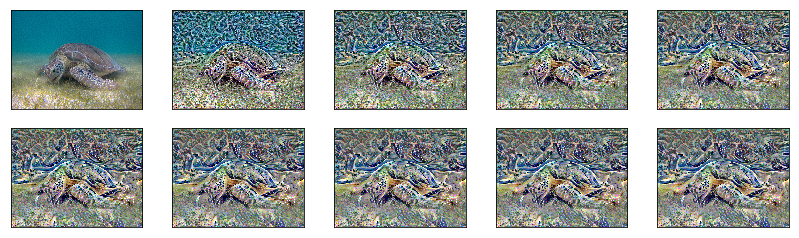

In [19]:
best, best_loss = run_style_transfer(content_path, 
                                     style_path, num_iterations=1000)

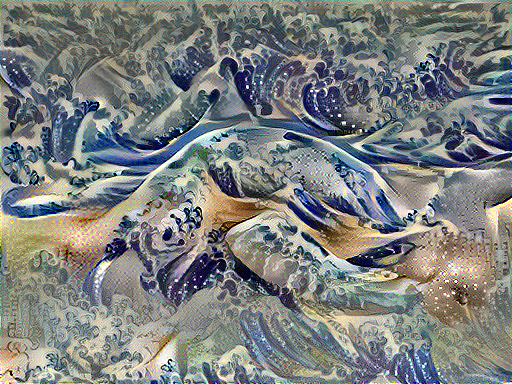

In [20]:
Image.fromarray(best)

In [21]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path)
    style = load_img(style_path)
    
    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')
    
    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')
    
    if show_large_final:
        plt.figure(figsize=(10, 10))
        
        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

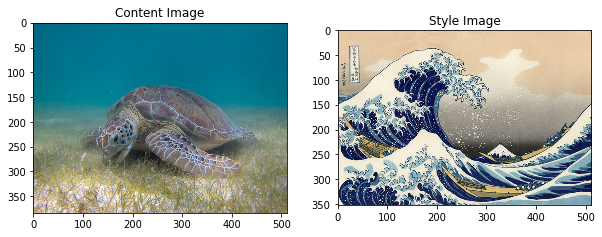

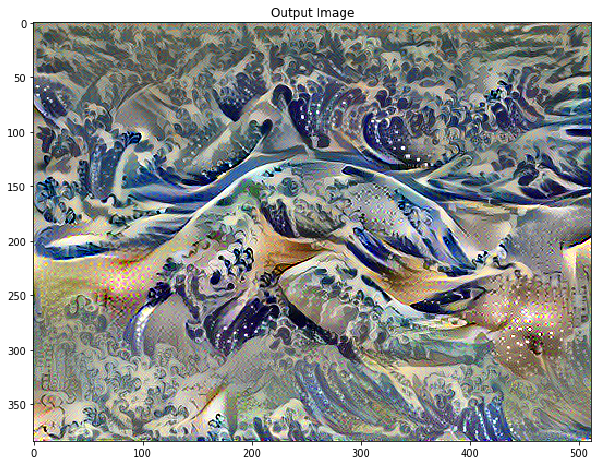

In [22]:
show_results(best, content_path, style_path)

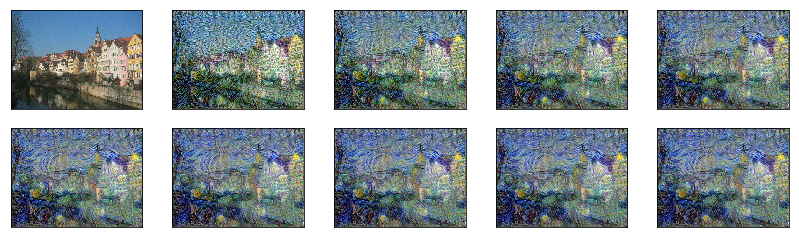

In [23]:
best_starry_night, best_loss = run_style_transfer('./tmp/nst/Tuebingen_Neckarfront.jpg',
                                                  './tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

In [ ]:
show_results(best_starry_night, './tmp/nst/Tuebingen_Neckarfront.jpg',
             './tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')